# **IMPORTING ALL REQUIRED LIBRARIES**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from xgboost import plot_importance
import lightgbm as lgb
# from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
import sklearn

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
## Reading the Data-Set
data = pd.read_csv('gdrive/My Drive/kaggle_challenges/ML Data Scientist Case Study Data.csv', sep = ";")

In [0]:
def data_missing_hit_split(data):
  """Function for splitting the Train And Test Date"""
  data_train = data[data['hits'] != r'\N'].reset_index().drop(columns = {'index'})
  data_test = data[data['hits'] == r'\N'].reset_index().drop(columns = {'index'})

    ## Unit Test for checking the split was Ok.
  if data_train.shape[0] + data_test.shape[0] == data.shape[0]:
    print('Data split OK...')
    return data_train, data_test

In [33]:
data_train, data_test = data_missing_hit_split(data)

Data split OK...


In [47]:
data.groupby(['day_of_week']).hits.count() ## Checking if there is any imbalance in the Data-Set

day_of_week
Friday       127740
Monday       158685
Saturday     119350
Sunday       144330
Thursday     136476
Tuesday      155001
Wednesday    147099
Name: hits, dtype: int64

In [0]:
def bar_chart(data, groupby_parameter):
  """Function for plotting bar-charts to check if there is any imbalance in the Data-Set"""
  objects = tuple(dict(data.groupby([groupby_parameter]).hits.count()).keys())
  y_pos = np.arange(len(objects))
    
  count = list(dict(data_train.groupby([groupby_parameter]).hits.count()).values())
  plt.bar(y_pos, count, align = 'center', alpha = 0.5)
  plt.xticks(y_pos, objects)

  plt.show()

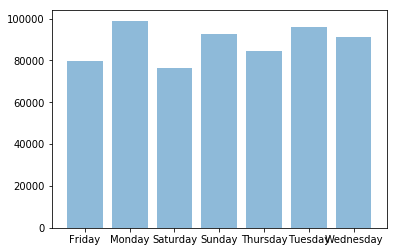

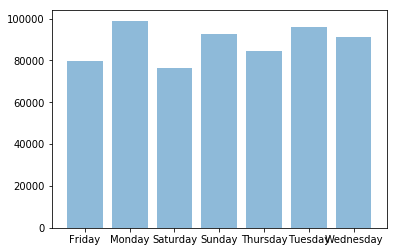

In [0]:
bar_chart(data_train, 'day_of_week')
bar_chart(data_test, 'day_of_week')

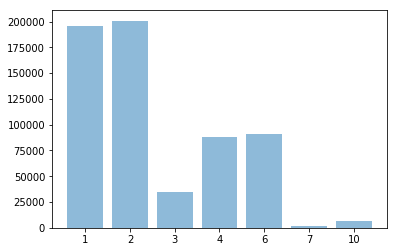

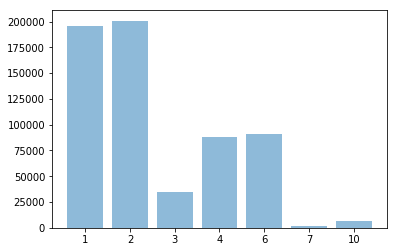

In [0]:
bar_chart(data_train, 'traffic_type')
bar_chart(data_test, 'traffic_type')

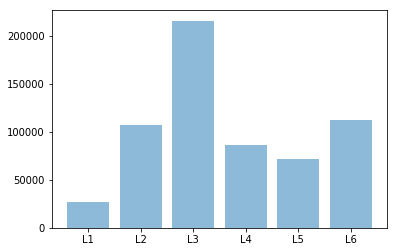

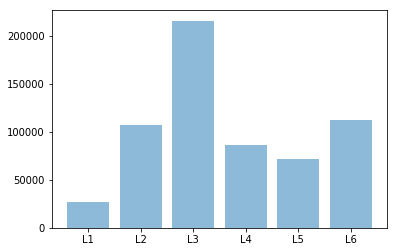

In [0]:
bar_chart(data_train, 'locale')
bar_chart(data_test, 'locale')

**As we can see from the above plots there are some imbalances in the classes. We will consider this in feature engineering.**

**FEATURE-ENGINEERING**

In [0]:
data_train = data_train[data_train['path_id_set'].isnull() == False]
data_test = data_test[data_test['path_id_set'].isnull() == False]

In [49]:
data_train.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
0,988680,L2,Thursday,22,10,2113,31965;0,2,49,14
1,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14
2,988678,L3,Saturday,19,8,2113,51462,6,0,1
3,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3
4,988676,L3,Monday,1,8,2100,0,1,0,2


In [0]:
data_train = data_train[data_train['session_durantion'] != '\\N'] ## removing null values from session_duration
data_test = data_test[data_test['session_durantion'] != '\\N']

data_train['hits'] = data_train['hits'].astype('int') ## Converting hits column to integer
data_train = data_train[data_train['hits'] <= 1000]

## Creating a new binary column where if 0 then no location visited else 1 if visited.
data_train.loc[data_train.path_id_set == '0', 'loc_visited'] = 0 
data_train['loc_visited'] = data_train['loc_visited'].fillna(1)
data_test.loc[data_test.path_id_set == '0', 'loc_visited'] = 0 
data_test['loc_visited'] = data_test['loc_visited'].fillna(1)


## Get count if visited any location or not variable name zero count which represents wether a location was visited or not.
zero_count = data_train['path_id_set'].str.split(';', n = 133, expand = True).isin({'0'}).sum(1)
zero_count_test = data_test['path_id_set'].str.split(';', n = 133, expand = True).isin({'0'}).sum(1)


## Creating a new columns where we add all postal codes together to get one single value.
data_train['all_loc_sum'] = data_train['path_id_set'].str.split(';', n= 133, expand = True).fillna(0).astype('int').sum(axis = 1)
data_test['all_loc_sum'] = data_test['path_id_set'].str.split(';', n= 133, expand = True).fillna(0).astype('int').sum(axis = 1)

In [0]:
def custom_encoding_ordinal_categorical_variables_day_of_week(data):
    
    """Seeing according to ISO 8601 Monday is the first day
    in a week we create the below dictionary for categorical variable"""
    
    day_dic = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
    data['day_of_week'] = data['day_of_week'].replace(day_dic)
    
    return data

In [0]:
def custom_encoding_ordinal_categorical_variables_locale(data):
    
    """Seeing from above that different locale are having different
        hits count so we need to treat them as ordinal categorical variables"""
    
    locale_dic = {'L1': 1, 'L2': 2, 'L3': 3, 'L4': 4, 'L5': 5, 'L6': 6}
    data['locale'] = data['locale'].replace(locale_dic)
    
    return data

In [38]:
custom_encoding_ordinal_categorical_variables_day_of_week(data_train)
custom_encoding_ordinal_categorical_variables_locale(data_train)
custom_encoding_ordinal_categorical_variables_day_of_week(data_test)
custom_encoding_ordinal_categorical_variables_locale(data_test)

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits,loc_visited,all_loc_sum
0,988681,6,1,17,1,2111,31672;0,6,7037,\N,1.0,31672
1,988666,3,4,16,10,2700,0;34387;84765,1,5189,\N,1.0,119152
2,988665,4,7,16,10,2113,79148;0,4,5,\N,1.0,79148
3,988664,3,2,19,6,2100,0;34602;34604,1,8041,\N,1.0,69206
4,988663,3,5,20,10,2111,34287;0;60579,2,117,\N,1.0,94866
5,988661,2,5,19,10,2113,46575;0,2,80,\N,1.0,46575
6,988660,2,4,20,1,2111,31467;0,2,26,\N,1.0,31467
7,988655,3,4,20,6,2100,0;34984;34421;34415;34998,3,1721,\N,1.0,138818
8,988654,6,6,15,6,2100,0;95235,1,44,\N,1.0,95235
9,988647,4,2,6,10,2116,78573;0,2,1494,\N,1.0,78573


In [0]:
## Column for total number of locations visited.
data_train['num_loc_visits'] = (data_train['path_id_set'].str.count(';') + 1) - zero_count
data_test['num_loc_visits'] = (data_test['path_id_set'].str.count(';') + 1) - zero_count_test

## Dropping the column path_id_set
data_train.drop(columns = {'path_id_set'}, inplace = True)
data_test.drop(columns = {'path_id_set'}, inplace = True)

## Converting session_duration to integer.
data_train['session_durantion'] = data_train['session_durantion'].astype('int')
data_test['session_durantion'] = data_test['session_durantion'].astype('int')

In [0]:
## A new columns which is the product of session_duration and num_loc_visits.
data_train['num_sess_visits'] = data_train['session_durantion'] * data_train['num_loc_visits']
data_test['num_sess_visits'] = data_test['session_durantion'] * data_test['num_loc_visits']

# data_train['num_loc_visits^2'] = data_train['num_loc_visits'] * data_train['num_loc_visits']
# data_train['session_durantion'] = data_train['session_durantion'] * data_train['session_durantion']

In [0]:
 ## Different aggregations for different categorical variables based on num_sess_visits and session_duration.
  
  GROUPBY_AGGREGATIONS = [
    {'groupby': ['agent_id','locale', 'traffic_type', 'day_of_week'], 'select': 'num_sess_visits', 'agg': 'var'},
    {'groupby': ['agent_id','locale', 'traffic_type', 'day_of_week'], 'select': 'num_sess_visits', 'agg': 'count'},
    {'groupby': ['agent_id','locale', 'traffic_type', 'day_of_week'], 'select': 'num_sess_visits', 'agg': 'mean'},
    {'groupby': ['agent_id', 'locale', 'traffic_type', 'entry_page'], 'select': 'num_sess_visits', 'agg': 'var'},
    {'groupby': ['agent_id', 'locale', 'traffic_type', 'entry_page'], 'select': 'num_sess_visits', 'agg': 'count'},
    {'groupby': ['agent_id', 'locale', 'traffic_type', 'entry_page'], 'select': 'num_sess_visits', 'agg': 'mean'},
    {'groupby': ['agent_id','locale', 'traffic_type', 'day_of_week'], 'select': 'session_durantion', 'agg': 'var'},
    {'groupby': ['agent_id','locale', 'traffic_type', 'day_of_week'], 'select': 'session_durantion', 'agg': 'count'},
    {'groupby': ['agent_id','locale', 'traffic_type', 'day_of_week'], 'select': 'session_durantion', 'agg': 'mean'},
    {'groupby': ['agent_id', 'locale', 'traffic_type', 'entry_page'], 'select': 'session_durantion', 'agg': 'var'},
    {'groupby': ['agent_id', 'locale', 'traffic_type', 'entry_page'], 'select': 'session_durantion', 'agg': 'count'},
    {'groupby': ['agent_id', 'locale', 'traffic_type', 'entry_page'], 'select': 'session_durantion', 'agg': 'mean'},
   # {'groupby': ['agent_id', 'locale'], 'select': 'traffic_type', 'agg': 'var'},
   # {'groupby': ['agent_id', 'locale'], 'select': 'traffic_type', 'agg': 'count'},
   # {'groupby': ['agent_id', 'locale'], 'select': 'traffic_type', 'agg': 'mean'}
    
 ]

In [0]:
for x in GROUPBY_AGGREGATIONS:
    
    agg_name = x['agg_name'] if 'agg_name' in x else x['agg']
    new_feature = '{}_{}_{}'.format('_'.join(x['groupby']), agg_name, x['select'])

    all_features = list(set(x['groupby'] + [x['select']]))
    nf = data_train[all_features]. \
    groupby(x['groupby'])[x['select']]. \
    agg(x['agg']). \
    reset_index(). \
    rename(index=str, columns={x['select']: new_feature})
    
    nf_test = data_test[all_features]. \
    groupby(x['groupby'])[x['select']]. \
    agg(x['agg']). \
    reset_index(). \
    rename(index=str, columns={x['select']: new_feature})
    
    data_train = data_train.merge(nf, on=x['groupby'], how='left')
    data_test = data_test.merge(nf_test, on=x['groupby'], how='left')

    

In [24]:
data_test.isnull().sum()

row_num                                                               0
locale                                                                0
day_of_week                                                           0
hour_of_day                                                           0
agent_id                                                              0
entry_page                                                            0
path_id_set                                                           0
traffic_type                                                          0
session_durantion                                                     0
hits                                                                  0
loc_visited                                                           0
all_loc_sum                                                           0
num_loc_visits                                                        0
num_sess_visits                                                 

In [43]:
## Getting the confRate for different categorical variables.
ATTRIBUTION_CATEGORIES = [
    ['agent_id'], ['locale'], ['traffic_type'], ['entry_page'],['day_of_week'],
    
    ['agent_id', 'locale'],
    ['agent_id', 'traffic_type'],
    ['agent_id', 'entry_page'],
    ['agent_id', 'day_of_week'],
    
    ['locale', 'traffic_type'],
    ['locale', 'entry_page'],
    ['locale', 'day_of_week'],
    ['traffic_type', 'entry_page'],
    ['traffic_type', 'day_of_week']
    
]


freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = data_train.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}. Group Max /Mean / Median / Min: {} / {} / {} / {}".format(
        cols, new_feature, 
        group_sizes.max(), 
        np.round(group_sizes.mean(), 2),
        np.round(group_sizes.median(), 2),
        group_sizes.min()
    ))
    
    # Aggregation function
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf
    
    # Perform the merge
    data_train = data_train.merge(
        group_object['session_durantion']. \
            apply(rate_calculation). \
            reset_index(). \
            rename( 
                index=str,
                columns={'session_durantion': new_feature}
            )[cols + [new_feature]],
        on=cols, how='left'
    )
    
data_train.head()

>> Calculating confidence-weighted rate for: ['agent_id'].
   Saving to: agent_id_confRate. Group Max /Mean / Median / Min: 190623 / 41040.33 / 16470.0 / 68
>> Calculating confidence-weighted rate for: ['locale'].
   Saving to: locale_confRate. Group Max /Mean / Median / Min: 213803 / 102600.83 / 96159.0 / 26285
>> Calculating confidence-weighted rate for: ['traffic_type'].
   Saving to: traffic_type_confRate. Group Max /Mean / Median / Min: 200746 / 87943.57 / 88204.0 / 1904
>> Calculating confidence-weighted rate for: ['entry_page'].
   Saving to: entry_page_confRate. Group Max /Mean / Median / Min: 205958 / 4526.51 / 8.0 / 1
>> Calculating confidence-weighted rate for: ['day_of_week'].
   Saving to: day_of_week_confRate. Group Max /Mean / Median / Min: 98409 / 87943.57 / 90641.0 / 75813
>> Calculating confidence-weighted rate for: ['agent_id', 'locale'].
   Saving to: agent_id_locale_confRate. Group Max /Mean / Median / Min: 57979 / 6916.91 / 993.0 / 1
>> Calculating confidence-weig

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits,loc_visited,all_loc_sum,num_loc_visits,num_sess_visits,agent_id_locale_traffic_type_day_of_week_var_num_sess_visits,agent_id_locale_traffic_type_day_of_week_count_num_sess_visits,agent_id_locale_traffic_type_day_of_week_mean_num_sess_visits,agent_id_locale_traffic_type_entry_page_var_num_sess_visits,agent_id_locale_traffic_type_entry_page_count_num_sess_visits,agent_id_locale_traffic_type_entry_page_mean_num_sess_visits,agent_id_locale_traffic_type_day_of_week_var_session_durantion,agent_id_locale_traffic_type_day_of_week_count_session_durantion,agent_id_locale_traffic_type_day_of_week_mean_session_durantion,agent_id_locale_traffic_type_entry_page_var_session_durantion,agent_id_locale_traffic_type_entry_page_count_session_durantion,agent_id_locale_traffic_type_entry_page_mean_session_durantion,agent_id_confRate,locale_confRate,traffic_type_confRate,entry_page_confRate,day_of_week_confRate,agent_id_locale_confRate,agent_id_traffic_type_confRate,agent_id_entry_page_confRate,agent_id_day_of_week_confRate,locale_traffic_type_confRate,locale_entry_page_confRate,locale_day_of_week_confRate,traffic_type_entry_page_confRate,traffic_type_day_of_week_confRate
0,988680,2,4,22,10,2113,31965;0,2,49,14,1.0,31965,1,49,1.353358e+07,1749,663.343625,2.380353e+06,4547,593.101825,6.336864e+05,1749,381.598056,6.556763e+05,4547,424.547614,558.646979,482.301452,425.191396,360.180537,484.560384,420.791358,369.050904,311.074848,488.487520,384.820218,359.828127,386.536519,488.007208,382.802867
1,988679,4,6,21,2,2100,0;78464,1,1892,14,1.0,78464,1,1892,1.298102e+07,87,1774.264368,2.487579e+07,766,2015.998695,2.317650e+06,87,1002.873563,3.822255e+06,766,1199.181462,536.618901,493.630269,879.942555,723.162819,481.317866,468.597100,795.664271,783.600553,431.796814,893.555652,672.522491,388.435172,795.775798,793.064625
2,988678,3,6,19,8,2113,51462,6,0,1,1.0,51462,1,0,9.699345e+05,593,229.168634,1.153708e+06,2197,237.023213,3.242005e+05,593,171.074199,3.341187e+05,2197,180.363678,374.155213,506.481565,216.336900,360.180537,481.317866,320.961121,200.982963,317.143913,297.892767,161.602853,341.660164,465.034876,206.821791,182.900657
3,988677,2,2,6,10,2116,31931;0,1,2,3,1.0,31931,1,2,2.920339e+07,1205,1244.926141,1.099056e+07,1945,556.923393,1.026756e+07,1205,707.818257,1.924045e+06,1945,271.495630,558.646979,482.301452,879.942555,252.564266,496.404723,420.791358,1144.234302,218.390018,501.211054,698.548089,239.709606,401.545067,240.530773,784.488878
4,988676,3,1,1,8,2100,0,1,0,2,0.0,0,0,0,2.074666e+07,902,1055.374723,7.679339e+06,3140,1085.317197,1.146855e+06,902,566.186253,1.142239e+06,3140,657.850000,374.155213,506.481565,879.942555,723.162819,495.985325,320.961121,481.219526,518.394897,319.241128,905.408882,588.129808,452.137906,795.775798,780.580680


In [45]:
## Getting the confRate for different categorical variables.
ATTRIBUTION_CATEGORIES = [
    ['agent_id'], ['locale'], ['traffic_type'], ['entry_page'],['day_of_week'],
    
    ['agent_id', 'locale'],
    ['agent_id', 'traffic_type'],
    ['agent_id', 'entry_page'],
    ['agent_id', 'day_of_week'],
    
    ['locale', 'traffic_type'],
    ['locale', 'entry_page'],
    ['locale', 'day_of_week'],
    ['traffic_type', 'entry_page'],
    ['traffic_type', 'day_of_week']
    
]


freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = data_test.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}. Group Max /Mean / Median / Min: {} / {} / {} / {}".format(
        cols, new_feature, 
        group_sizes.max(), 
        np.round(group_sizes.mean(), 2),
        np.round(group_sizes.median(), 2),
        group_sizes.min()
    ))
    
    # Aggregation function
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf
    
    # Perform the merge
    data_test = data_test.merge(
        group_object['session_durantion']. \
            apply(rate_calculation). \
            reset_index(). \
            rename( 
                index=str,
                columns={'session_durantion': new_feature}
            )[cols + [new_feature]],
        on=cols, how='left'
    )
    
data_test.isnull().sum()

>> Calculating confidence-weighted rate for: ['agent_id'].
   Saving to: agent_id_confRate. Group Max /Mean / Median / Min: 95750 / 22966.0 / 8409.5 / 31
>> Calculating confidence-weighted rate for: ['locale'].
   Saving to: locale_confRate. Group Max /Mean / Median / Min: 135958 / 61242.67 / 55140.0 / 15000
>> Calculating confidence-weighted rate for: ['traffic_type'].
   Saving to: traffic_type_confRate. Group Max /Mean / Median / Min: 114574 / 52493.71 / 47993.0 / 1080
>> Calculating confidence-weighted rate for: ['entry_page'].
   Saving to: entry_page_confRate. Group Max /Mean / Median / Min: 127195 / 2987.45 / 6.0 / 1
>> Calculating confidence-weighted rate for: ['day_of_week'].
   Saving to: day_of_week_confRate. Group Max /Mean / Median / Min: 59408 / 52493.71 / 51642.0 / 42757
>> Calculating confidence-weighted rate for: ['agent_id', 'locale'].
   Saving to: agent_id_locale_confRate. Group Max /Mean / Median / Min: 29404 / 3909.11 / 686.5 / 1
>> Calculating confidence-weighted

row_num                                                               0
locale                                                                0
day_of_week                                                           0
hour_of_day                                                           0
agent_id                                                              0
entry_page                                                            0
traffic_type                                                          0
session_durantion                                                     0
hits                                                                  0
loc_visited                                                           0
all_loc_sum                                                           0
num_loc_visits                                                        0
num_sess_visits                                                       0
agent_id_locale_traffic_type_day_of_week_var_num_sess_visits    

In [0]:
## Converting hours to minutes and seconds.
data_train['min_of_day'] = data_train['hour_of_day'] * 60
data_train['sec_of_day'] = data_train['min_of_day'] * 60

data_test['min_of_day'] = data_test['hour_of_day'] * 60
data_test['sec_of_day'] = data_test['min_of_day'] * 60

In [0]:
## Removing missing values
data_train = data_train[data_train['agent_id_locale_traffic_type_day_of_week_var_num_sess_visits'].isnull() == False]
data_train['agent_id_locale_traffic_type_entry_page_var_num_sess_visits'].fillna(data_train['agent_id_locale_traffic_type_entry_page_var_num_sess_visits'].mean(), inplace = True)
data_train['agent_id_locale_traffic_type_entry_page_var_session_durantion'].fillna(data_train['agent_id_locale_traffic_type_entry_page_var_session_durantion'].mean(), inplace = True)

## Removing missing values
data_test = data_test[data_test['agent_id_locale_traffic_type_day_of_week_var_num_sess_visits'].isnull() == False]
data_test['agent_id_locale_traffic_type_entry_page_var_num_sess_visits'].fillna(data_test['agent_id_locale_traffic_type_entry_page_var_num_sess_visits'].mean(), inplace = True)
data_test['agent_id_locale_traffic_type_entry_page_var_session_durantion'].fillna(data_test['agent_id_locale_traffic_type_entry_page_var_session_durantion'].mean(), inplace = True)

In [0]:
## Creating new binary variable which show wether it is a weekend or any other day.
data_train['Is_Mon'] = (data_train['day_of_week'] == 1) * 1
data_train['Is_Tue'] = (data_train['day_of_week'] == 2) * 1
data_train['Is_Wed'] = (data_train['day_of_week'] == 3) * 1
data_train['Is_Thu'] = (data_train['day_of_week'] == 4) * 1
data_train['Is_Fri'] = (data_train['day_of_week'] == 5) * 1
data_train['Is_Sat'] = (data_train['day_of_week'] == 6) * 1
data_train['Is_Sun'] = (data_train['day_of_week'] == 7) * 1
data_train['Is_Wek'] = (data_train['day_of_week']) // 5


data_test['Is_Mon'] = (data_test['day_of_week'] == 1) * 1
data_test['Is_Tue'] = (data_test['day_of_week'] == 2) * 1
data_test['Is_Wed'] = (data_test['day_of_week'] == 3) * 1
data_test['Is_Thu'] = (data_test['day_of_week'] == 4) * 1
data_test['Is_Fri'] = (data_test['day_of_week'] == 5) * 1
data_test['Is_Sat'] = (data_test['day_of_week'] == 6) * 1
data_test['Is_Sun'] = (data_test['day_of_week'] == 7) * 1
data_test['Is_Wek'] = (data_test['day_of_week']) // 5

In [0]:
## Considering the data has some temporal aspect we sort the data by row_num
data_train = data_train.sort_values('row_num')
data_test = data_test.sort_values('row_num')


## Removing features based on feature importance graph from xgboost.
data_train.drop(columns={ 'Is_Thu', 'locale_confRate', 'Is_Sat', 'day_of_week'}, inplace = True)
data_test.drop(columns={ 'Is_Thu', 'locale_confRate', 'Is_Sat', 'day_of_week'}, inplace = True)

In [0]:
## Splitting the Data in train, test and Cross-Validation

Y = data_train['hits']
X = data_train.drop(columns={'hits'}, axis = 1)

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.30, random_state = 42)

crov_X, test_X, crov_Y, test_Y = train_test_split(test_X, test_Y, test_size = 0.20, random_state = 42)

**MODELING**

In [0]:
def xgboost(x_train, y_train, x_test, y_test):
  
  """Function for training an xgboost algorithm the parameters have been
      selected after reading several kernels from kaggle and Xgboost Documentation.
      Currently using params not params_2 as it makes the model very slow."""
  
    dtrain = xgb.DMatrix(x_train, label = y_train, feature_names = list(x_train.columns))
    dtest = xgb.DMatrix(x_test, label = y_test, feature_names = list(x_test.columns))
    
    params_2 = {'booster': 'dart',
         'max_depth': 21, 'learning_rate': 0.1,
         'silent': True,
         'sample_type': 'uniform',
         'normalize_type': 'tree',
         'rate_drop': 0.1,
         'tree_method': 'gpu_hist',
         'skip_drop': 0.5}
    
    params = {'max_depth': 3,
              'alpha': 10,
              'eta': 0.01,
              'learning_rate': 0.01,
              'tree_method': 'gpu_hist',
              'silent': 1,
               'subsample': 1}
    
    
    
    bst = xgb.train(params=params,
                    dtrain=dtrain,
                    num_boost_round=3500,
                    early_stopping_rounds=100,
                    evals=[(dtest, 'valid'), (dtrain, 'train')],
                    verbose_eval=20)
    
    
    plot_importance(bst) ## Function for plotting importance of all features
    
    return pd.Series(bst.predict(dtest))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	valid-rmse:41.8009	train-rmse:43.442
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 100 rounds.
[20]	valid-rmse:38.7494	train-rmse:40.4669
[40]	valid-rmse:36.5077	train-rmse:38.2976
[60]	valid-rmse:34.8857	train-rmse:36.7297
[80]	valid-rmse:33.7177	train-rmse:35.5949
[100]	valid-rmse:32.8742	train-rmse:34.7689
[120]	valid-rmse:32.2787	train-rmse:34.1776
[140]	valid-rmse:31.859	train-rmse:33.752
[160]	valid-rmse:31.5657	train-rmse:33.4458
[180]	valid-rmse:31.3567	train-rmse:33.2199
[200]	valid-rmse:31.2087	train-rmse:33.0481
[220]	valid-rmse:31.104	train-rmse:32.9146
[240]	valid-rmse:31.019	train-rmse:32.7968
[260]	valid-rmse:30.9535	train-rmse:32.7015
[280]	valid-rmse:30.9069	train-rmse:32.6244
[300]	valid-rmse:30.8734	train-rmse:32.5589
[320]	valid-rmse:30.8494	train-rmse:32.5007
[340]	valid-rmse:30.833	train-rmse:32.4504
[360]	valid-rmse:30.8202	train-rmse:32.4118
[380]	valid-rmse:30.81	train-r

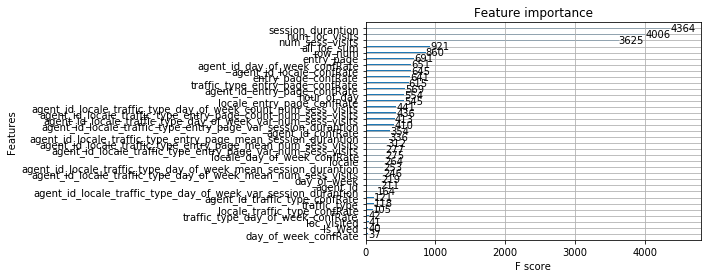

In [149]:
## Training the model
preds = pd.DataFrame(xgboost(train_X, train_Y, crov_X, crov_Y)).reset_index()
preds.columns = ['row_num', 'hits']

In [51]:
"""Training a lgbm model the parameters are selected
   after reading a lot of kaggle kernels and lgbm documentation"""
dtrain = lgb.Dataset(train_X, train_Y)
dtest = lgb.Dataset(crov_X, crov_Y, reference=dtrain)
  
params = {}
params['max_bin'] = 256,
params['max_depth'] = 512
params['learning_rate'] = 0.001 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.50      # feature_fraction 
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0
n_estimators = 5000


lgbm = lgb.train(params, dtrain, num_boost_round=5000, valid_sets= dtest, early_stopping_rounds=100)

[1]	valid_0's l1: 17.6899
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l1: 17.6782
[3]	valid_0's l1: 17.6745
[4]	valid_0's l1: 17.6627
[5]	valid_0's l1: 17.6549
[6]	valid_0's l1: 17.6471
[7]	valid_0's l1: 17.6394
[8]	valid_0's l1: 17.6277
[9]	valid_0's l1: 17.6164
[10]	valid_0's l1: 17.6054
[11]	valid_0's l1: 17.5938
[12]	valid_0's l1: 17.586
[13]	valid_0's l1: 17.5745
[14]	valid_0's l1: 17.5628
[15]	valid_0's l1: 17.5512
[16]	valid_0's l1: 17.5434
[17]	valid_0's l1: 17.5318
[18]	valid_0's l1: 17.5202
[19]	valid_0's l1: 17.5087
[20]	valid_0's l1: 17.4972
[21]	valid_0's l1: 17.4909
[22]	valid_0's l1: 17.4795
[23]	valid_0's l1: 17.4684
[24]	valid_0's l1: 17.457
[25]	valid_0's l1: 17.4455
[26]	valid_0's l1: 17.4392
[27]	valid_0's l1: 17.4316
[28]	valid_0's l1: 17.4201
[29]	valid_0's l1: 17.4088
[30]	valid_0's l1: 17.3974
[31]	valid_0's l1: 17.3861
[32]	valid_0's l1: 17.3748
[33]	valid_0's l1: 17.3672
[34]	valid_0's l1: 17.3559
[35]	valid_0's l1: 17.3446
[36

In [52]:
## lgbm much faster and showing better accuracy then xgboost so
## selected this algorithm for final results.
print('Starting predicting...')
# predict
y_pred = lgbm.predict(test_X, num_iteration=lgbm.best_iteration)
y_train_pred = lgbm.predict(train_X, num_iteration=lgbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(test_Y, y_pred) ** 0.5)
print('The rmse of prediction is:', mean_squared_error(train_Y, y_train_pred) ** 0.5)

Starting predicting...
The rmse of prediction is: 28.75008172153785
The rmse of prediction is: 27.447808417568105


In [0]:
data_test.drop(columns={'hits'}, inplace = True)

In [0]:
y_pred_test = lgbm.predict(data_test, num_iteration=lgbm.best_iteration)
df = pd.DataFrame()
df['row_num'] = data_test['row_num']
df['hits'] = y_pred_test

df.to_csv('data_test_prediction.csv')

**As we can see by using L1 regularization makes the training rmse larger than test rmse. Thus
making over-fitting minimum.**




In [0]:
train_features = [x for x in train_X.columns]
imp_df = pd.DataFrame()
imp_df["feature"] = list(train_features)
imp_df["importance_gain"] = lgbm.feature_importance(importance_type='gain')
imp_df["importance_split"] = lgbm.feature_importance(importance_type='split')
imp_df['trn_score'] = mean_squared_error(data_train['hits'], lgbm.predict(data_train[train_features]))**0.5

In [0]:
params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.01 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.50      # feature_fraction 
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0

In [110]:
## Experimenting with k-crossvalidation
lgbm = lgb.cv(params, dtrain, num_boost_round=5000, early_stopping_rounds=100, nfold=3)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [111]:
print('Current parameters:\n', params)
print('\nBest num_boost_round:', len(lgbm['l1-mean']))
print('Best CV score:', lgbm['l1-mean'][-1])

Current parameters:
 {'max_bin': 10, 'learning_rate': 0.01, 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'l1', 'sub_feature': 0.5, 'bagging_fraction': 0.85, 'bagging_freq': 40, 'num_leaves': 512, 'min_data': 500, 'min_hessian': 0.05, 'verbose': 0}

Best num_boost_round: 472
Best CV score: 10.347176878356175
